In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
import os
import time
import warnings
import numpy as np
from numpy import newaxis
import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import pyedflib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Hide messy TensorFlow warnings
warnings.filterwarnings("ignore") #Hide messy Numpy warnings

# create a differenced series
def difference(dataset, interval=1):
    diff = np.zeros((dataset.shape[0],dataset.shape[1]))
    for k in range(dataset.shape[0]):
        for i in range(interval, dataset.shape[1]):
            diff[k,i] = dataset[k,i] - dataset[k,i - interval]
            
    return diff

def load_data(filename):
    g = pyedflib.EdfReader(filename)
    n = g.signals_in_file
    signal_labels = g.getSignalLabels()
    sig = np.zeros((n, g.getNSamples()[0]))
    for i in np.arange(n):
        len_sig = len(g.readSignal(i))
        sig[i, :len_sig] = g.readSignal(i)
    return sig
def make_data(sig, seq_len, normalise_window):
    

    data = sig[:2,:500]
    
    if not normalise_window:
        data = difference(data,1)
    
    sequence_length = seq_len + 1
    
    result = np.zeros((data.shape[0],data.shape[1] - sequence_length, sequence_length))
    for index in range(data.shape[1] - sequence_length):
        for k in range(data.shape[0]):
            result[k,index] = data[k,index: index + sequence_length]
    print result[:,0]
    if normalise_window:
        result = normalise_windows(result)
    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    #np.random.shuffle(train)
    old_x_train = train[:,:, :-1]
    y_train = train[:,:, -1]
    old_x_test = result[:,int(row):, :-1]
    y_test = result[:,int(row):, -1]

    x_train = np.zeros((old_x_train.shape[1], old_x_train.shape[2], old_x_train.shape[0]))
    for i in range(old_x_train.shape[1]):
        for k in range(old_x_train.shape[2]):
            vals = np.zeros(old_x_train.shape[0])
            for index in range(old_x_train.shape[0]):
                vals[index] = old_x_train[index,i,k]
                #print vals
            x_train[i,k] = vals
    
    x_test = np.zeros((old_x_test.shape[1], old_x_test.shape[2], old_x_test.shape[0]))
    for i in range(old_x_test.shape[1]):
        for k in range(old_x_test.shape[2]):
            vals = np.zeros(old_x_test.shape[0])
            for index in range(old_x_test.shape[0]):
                vals[index] = old_x_train[index,i,k]
            x_test[i,k] = vals

    return [x_train, y_train.T, x_test, y_test.T]

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data
        
def build_model(layers):
    model = Sequential()
    print(layers)
    model.add(LSTM(
        input_shape=(layers[1], layers[0]),
        output_dim=layers[3],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    return model



In [3]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))

In [13]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    #predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [5]:
import time
import matplotlib.pyplot as plt

def plot_results(predicted_data, true_data, make_line):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    if make_line:
        plt.axvline(x=y_train.shape[0] + 1, linestyle='--', color = 'b', label = 'future predicted points')
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [6]:
global_start_time = time.time()
seq_len = 50

print('> Loading data... ')
sig = load_data('sample-data/SC4001E0-PSG.edf')




> Loading data... 


In [7]:
X_train, y_train, X_test, y_test = make_data(sig, seq_len, False)
print(X_train.shape, y_train.shape)

[[  0.          -7.5956044    3.93846154  -3.75091575  -2.81318681
   -2.25054945  -0.84395604   1.40659341   3.18827839   2.71941392
    3.18827839  -0.18754579  -0.37509158  -4.31355311   1.87545788
    2.15677656   1.5003663   -5.06373626   2.71941392   5.34505495
   -7.5956044   -1.31282051   5.90769231   4.96996337  -4.87619048
   -3.93846154  -0.93772894  -4.78241758  -0.84395604   2.71941392
   -7.78315018   3.37582418  -3.09450549   4.03223443  -8.06446886
   -4.78241758  -2.53186813   2.43809524   1.03150183  -3.56336996
   -2.34432234   0.46886447  -0.46886447  -0.56263736   3.84468864
    0.37509158   0.93772894   4.87619048   0.56263736   4.68864469
   -0.18754579]
 [  0.           3.93479853  -5.56630037   1.43956044   1.91941392
   -0.67179487   0.47985348   2.78315018  -2.68717949   0.
   -9.78901099  -2.78315018   2.59120879   6.52600733   0.86373626
    0.38388278   1.43956044  -6.43003663   2.20732601  -1.63150183
    3.74285714   1.72747253  -1.43956044  -7.29377289 

In [8]:
print('> Data Loaded. Compiling...')
epochs  = 450
model = build_model([X_train.shape[2], X_train.shape[1], 100, X_train.shape[2]])
history = LossHistory()
filepath = '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
save_model = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

#history = keras.callbacks.Callback()
model.fit(X_train, y_train, batch_size=250, nb_epoch=epochs, validation_split=0.05, callbacks=[history])

#predictions = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
#predicted = lstm.predict_sequence_full(model, X_test, seq_len)


> Data Loaded. Compiling...
[2, 50, 100, 2]
('> Compilation Time : ', 0.011198043823242188)
Train on 426 samples, validate on 23 samples
Epoch 1/450
426/426 [==============================] - 2s 4ms/step - loss: 72.9068 - val_loss: 56.9506
Epoch 2/450
426/426 [==============================] - 0s 677us/step - loss: 72.8414 - val_loss: 56.9852
Epoch 3/450
426/426 [==============================] - 0s 663us/step - loss: 72.6964 - val_loss: 57.0911
Epoch 4/450
426/426 [==============================] - 0s 649us/step - loss: 72.4340 - val_loss: 56.8966
Epoch 5/450
426/426 [==============================] - 0s 652us/step - loss: 71.7928 - val_loss: 56.3218
Epoch 6/450
426/426 [==============================] - 0s 671us/step - loss: 70.7283 - val_loss: 57.6289
Epoch 7/450
426/426 [==============================] - 0s 648us/step - loss: 70.8648 - val_loss: 57.4401
Epoch 8/450
426/426 [==============================] - 0s 696us/step - loss: 70.3599 - val_loss: 57.3406
Epoch 9/450
426/426 [====

426/426 [==============================] - 0s 706us/step - loss: 61.2532 - val_loss: 54.4782
Epoch 78/450
426/426 [==============================] - 0s 706us/step - loss: 60.4747 - val_loss: 54.3183
Epoch 79/450
426/426 [==============================] - 0s 749us/step - loss: 60.9410 - val_loss: 54.5097
Epoch 80/450
426/426 [==============================] - 0s 748us/step - loss: 60.7532 - val_loss: 54.5549
Epoch 81/450
426/426 [==============================] - 0s 717us/step - loss: 61.3383 - val_loss: 54.9593
Epoch 82/450
426/426 [==============================] - 0s 661us/step - loss: 61.2162 - val_loss: 54.9206
Epoch 83/450
426/426 [==============================] - 0s 698us/step - loss: 60.5364 - val_loss: 54.4831
Epoch 84/450
426/426 [==============================] - 0s 729us/step - loss: 60.5175 - val_loss: 54.5483
Epoch 85/450
426/426 [==============================] - 0s 777us/step - loss: 60.8155 - val_loss: 55.0919
Epoch 86/450
426/426 [==============================] - 0s 

Epoch 154/450
426/426 [==============================] - 0s 684us/step - loss: 56.4062 - val_loss: 55.8317
Epoch 155/450
426/426 [==============================] - 0s 673us/step - loss: 56.6817 - val_loss: 57.1789
Epoch 156/450
426/426 [==============================] - 0s 777us/step - loss: 56.9490 - val_loss: 58.2678
Epoch 157/450
426/426 [==============================] - 0s 695us/step - loss: 56.4199 - val_loss: 57.0889
Epoch 158/450
426/426 [==============================] - 0s 710us/step - loss: 57.5364 - val_loss: 55.6703
Epoch 159/450
426/426 [==============================] - 0s 712us/step - loss: 59.5104 - val_loss: 55.5836
Epoch 160/450
426/426 [==============================] - 0s 687us/step - loss: 57.4708 - val_loss: 57.1963
Epoch 161/450
426/426 [==============================] - 0s 671us/step - loss: 57.4230 - val_loss: 56.3065
Epoch 162/450
426/426 [==============================] - 0s 641us/step - loss: 56.5072 - val_loss: 56.0198
Epoch 163/450
426/426 [==============

426/426 [==============================] - 0s 675us/step - loss: 55.0487 - val_loss: 64.1625
Epoch 231/450
426/426 [==============================] - 0s 704us/step - loss: 52.9308 - val_loss: 66.6818
Epoch 232/450
426/426 [==============================] - 0s 805us/step - loss: 54.2417 - val_loss: 61.5013
Epoch 233/450
426/426 [==============================] - 0s 698us/step - loss: 54.1192 - val_loss: 64.6290
Epoch 234/450
426/426 [==============================] - 0s 725us/step - loss: 54.5703 - val_loss: 63.6206
Epoch 235/450
426/426 [==============================] - 0s 722us/step - loss: 53.7727 - val_loss: 67.8115
Epoch 236/450
426/426 [==============================] - 0s 704us/step - loss: 54.4931 - val_loss: 58.2003
Epoch 237/450
426/426 [==============================] - 0s 672us/step - loss: 55.0440 - val_loss: 64.8586
Epoch 238/450
426/426 [==============================] - 0s 727us/step - loss: 54.8784 - val_loss: 61.9067
Epoch 239/450
426/426 [============================

426/426 [==============================] - 0s 705us/step - loss: 51.9376 - val_loss: 63.1274
Epoch 307/450
426/426 [==============================] - 0s 660us/step - loss: 52.6070 - val_loss: 66.0540
Epoch 308/450
426/426 [==============================] - 0s 698us/step - loss: 51.2832 - val_loss: 62.8374
Epoch 309/450
426/426 [==============================] - 0s 702us/step - loss: 50.5271 - val_loss: 67.8599
Epoch 310/450
426/426 [==============================] - 0s 775us/step - loss: 52.0396 - val_loss: 73.7641
Epoch 311/450
426/426 [==============================] - 0s 696us/step - loss: 53.4602 - val_loss: 73.6604
Epoch 312/450
426/426 [==============================] - 0s 680us/step - loss: 58.9888 - val_loss: 65.8183
Epoch 313/450
426/426 [==============================] - 0s 691us/step - loss: 51.6585 - val_loss: 71.5925
Epoch 314/450
426/426 [==============================] - 0s 683us/step - loss: 53.0594 - val_loss: 70.9814
Epoch 315/450
426/426 [============================

426/426 [==============================] - 0s 712us/step - loss: 52.8022 - val_loss: 62.6394
Epoch 383/450
426/426 [==============================] - 0s 687us/step - loss: 50.2337 - val_loss: 62.9250
Epoch 384/450
426/426 [==============================] - 0s 679us/step - loss: 50.0186 - val_loss: 62.0727
Epoch 385/450
426/426 [==============================] - 0s 677us/step - loss: 51.1844 - val_loss: 62.4253
Epoch 386/450
426/426 [==============================] - 0s 686us/step - loss: 49.1284 - val_loss: 64.7594
Epoch 387/450
426/426 [==============================] - 0s 724us/step - loss: 49.3117 - val_loss: 64.8704
Epoch 388/450
426/426 [==============================] - 0s 710us/step - loss: 48.7197 - val_loss: 59.3099
Epoch 389/450
426/426 [==============================] - 0s 735us/step - loss: 51.6875 - val_loss: 60.8803
Epoch 390/450
426/426 [==============================] - 0s 651us/step - loss: 50.4629 - val_loss: 70.7026
Epoch 391/450
426/426 [============================

(449, 2)
('Training duration (s) : ', 339.6634340286255)
(447, 2)


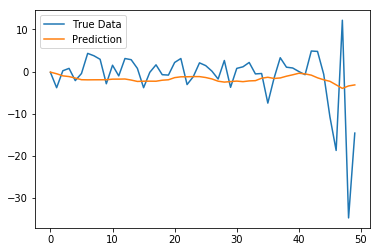

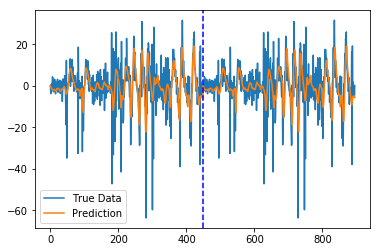

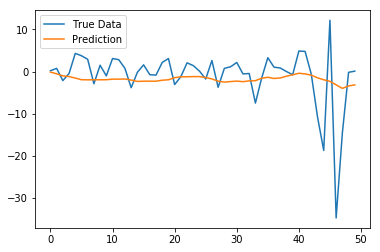

(449, 2)
('Training duration (s) : ', 340.9835171699524)
(447, 2)


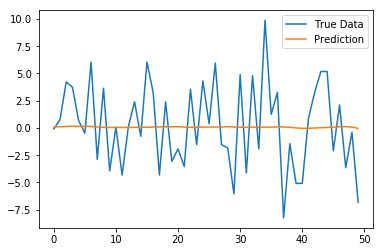

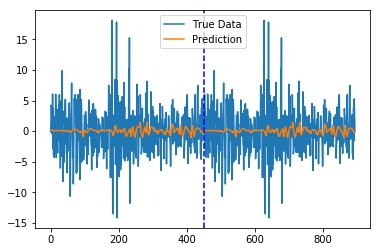

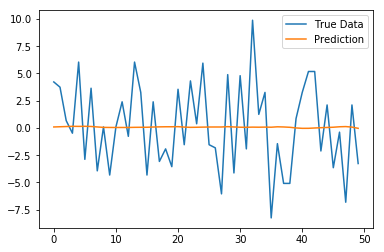

In [14]:
for i in range(X_train.shape[2]):
    predicted = predict_point_by_point(model, X_test)        
    predicted_train = predict_point_by_point(model, X_train)
    print(predicted_train.shape)
    print('Training duration (s) : ', time.time() - global_start_time)
    print predicted.shape
    plot_results(predicted_train[:50, i], y_train[:50,i], False)
    plot_results(np.concatenate([predicted_train[:,i],predicted[:,i]]), np.concatenate([y_train[:,i],y_test[:,i]]), True)
    plot_results(predicted[:50,i], y_test[:50,i], False)

In [ ]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(range(len(history.losses)),history.losses, label='loss')
plt.plot(range(len(history.val_losses)),history.val_losses, label='val loss') 
plt.legend()
plt.show()

In [ ]:
predicted = lstm.predict_sequences_multiple(model, X_test, seq_len, 50)
predicted_train = lstm.predict_sequences_multiple(model, X_train, seq_len, 50)
plot_results(predicted_train[:50], y_train[:50], False)
plot_results(np.concatenate([predicted_train,predicted]), np.concatenate([y_train,y_test]), True)
plot_results_multiple(predicted[:50], y_test[:50], 50, False)

In [ ]:
predicted = lstm.predict_sequence_full(model, X_test, seq_len)
predicted_train = lstm.predict_sequence_full(model, X_train, seq_len)